***Importing Libraies***

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import json
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

%matplotlib inline

In [2]:
data_dir = r"/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"

In [3]:
diseases = os.listdir(train_dir)
print(diseases)

['Tomato___Late_blight', 'Tomato___healthy', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Potato___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Strawberry___Leaf_scorch', 'Peach___healthy', 'Apple___Apple_scab', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Apple___Black_rot', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Peach___Bacterial_spot', 'Apple___Cedar_apple_rust', 'Tomato___Target_Spot', 'Pepper,_bell___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Late_blight', 'Tomato___Tomato_mosaic_virus', 'Strawberry___healthy', 'Apple___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Common_rust_', 'Grape___Esca_(Black_Measles)', 'Raspberry___healthy', 'Tomato___Leaf_Mold', 'Tomato__

In [4]:
print(f"Total Disease Classes are {len(diseases)}")

Total Disease Classes are 38


In [5]:
crops=[]
number_of_diseases=0
for crop in diseases:
    if crop.split('___')[0] not in crops:
        crops.append(crop.split('___')[0])
    if crop.split('___')[1] != 'healthy':
        number_of_diseases+=1

In [6]:
print(f'Unique Crops are : \n{crops}')

Unique Crops are : 
['Tomato', 'Grape', 'Orange', 'Soybean', 'Squash', 'Potato', 'Corn_(maize)', 'Strawberry', 'Peach', 'Apple', 'Blueberry', 'Cherry_(including_sour)', 'Pepper,_bell', 'Raspberry']


In [7]:
print(f"Number of Crops : {len(crops)}")

Number of Crops : 14


In [8]:
print(f"Number of Unique Diseases :{number_of_diseases}")

Number of Unique Diseases :26


In [9]:
numbers = {}
for disease in diseases:
    numbers[disease] = len(os.listdir(train_dir + '/' + disease))

image_per_class = pd.DataFrame(numbers.values(), index=numbers.keys(), columns=["Number of Images"])
image_per_class

,Number of Images
Tomato___Late_blight,1851
Tomato___healthy,1926
Grape___healthy,1692
Orange___Haunglongbing_(Citrus_greening),2010
Soybean___healthy,2022
Squash___Powdery_mildew,1736
Potato___healthy,1824
Corn_(maize)___Northern_Leaf_Blight,1908
Tomato___Early_blight,1920
Tomato___Septoria_leaf_spot,1745


***Performing Exploratory Data Analysis (EDA)***

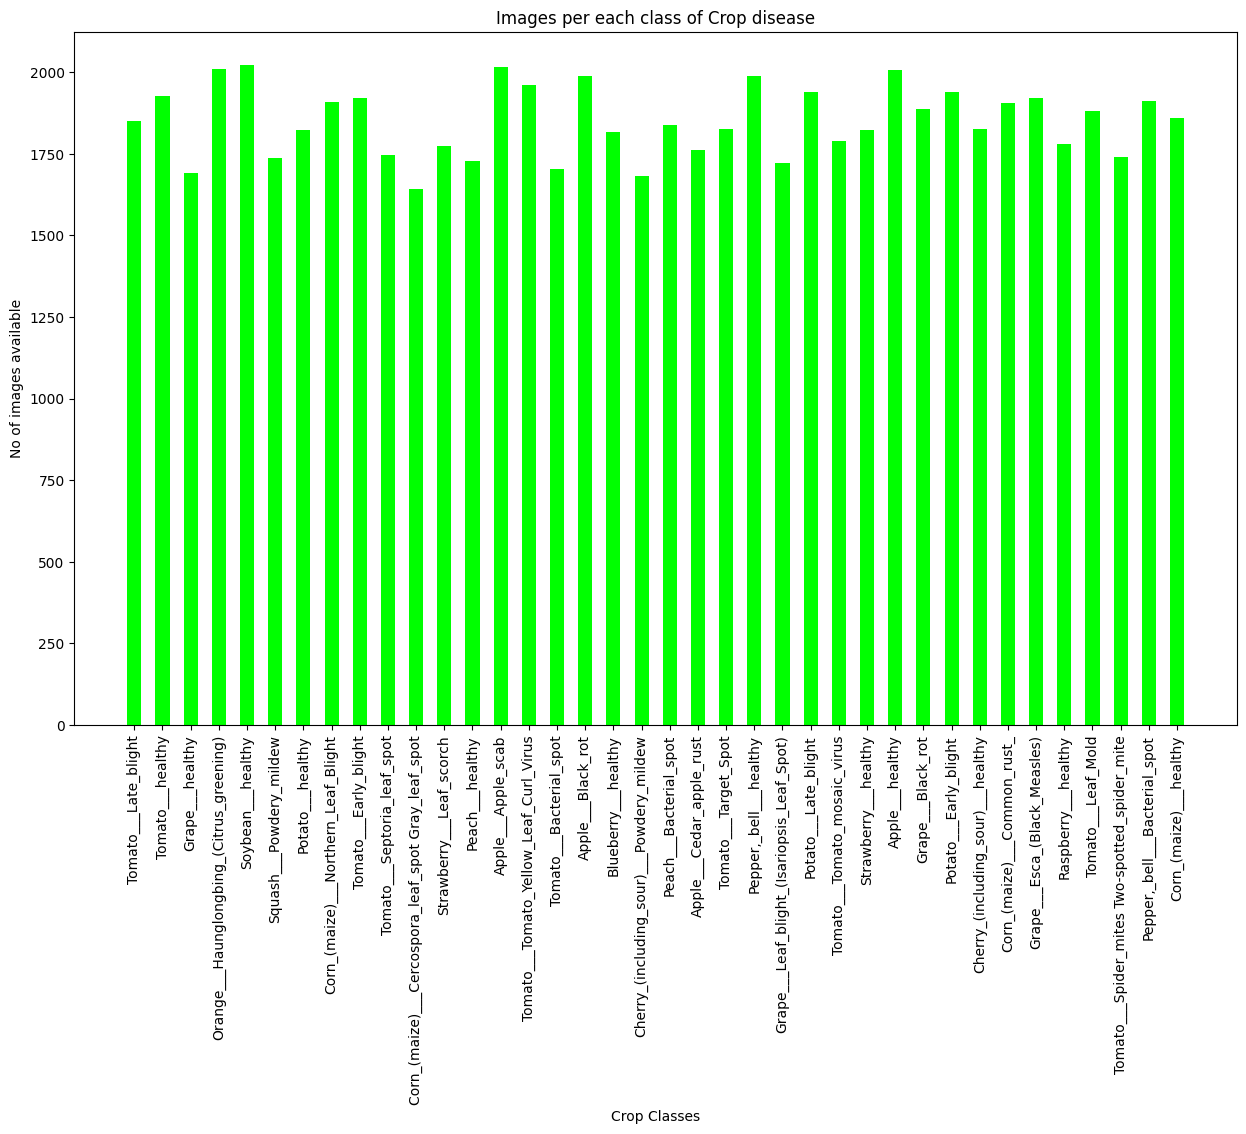

In [10]:
index = [i for i in range(38)]
plt.figure(figsize=(15, 9))
plt.bar(index, [i for i in numbers.values()], width=0.5,color='lime')
plt.xlabel('Crop Classes', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, diseases, fontsize=10, rotation=90)
plt.title('Images per each class of Crop disease')
plt.show()

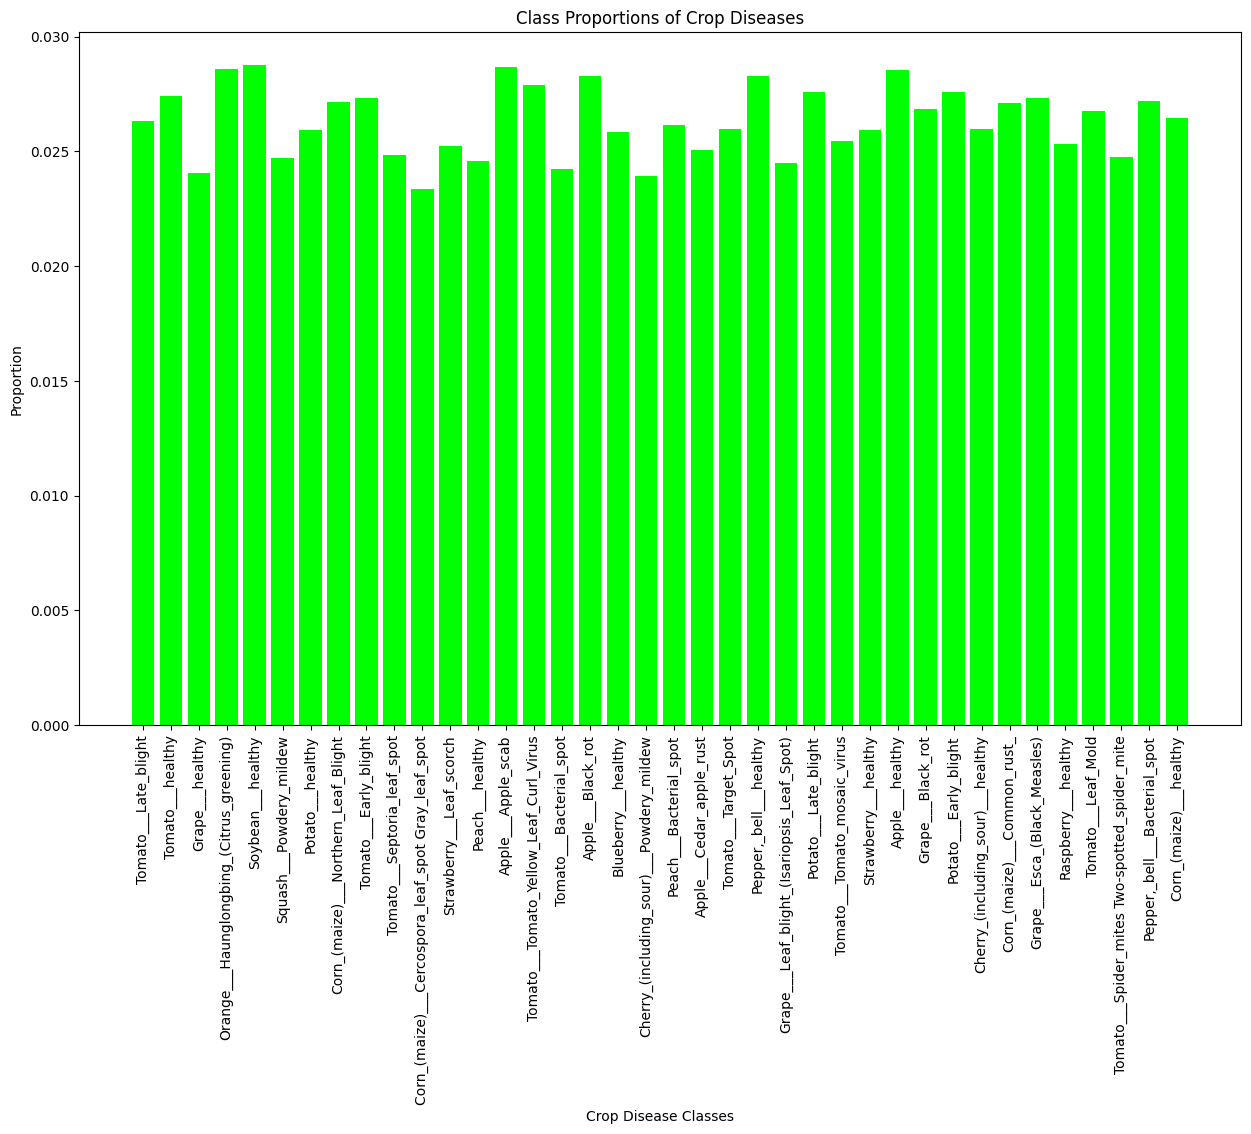

In [11]:
total_images = sum(numbers.values())

class_proportions = {disease: count / total_images for disease, count in numbers.items()}

plt.figure(figsize=(15, 9))
plt.bar(class_proportions.keys(), class_proportions.values(), color='lime')

plt.xlabel('Crop Disease Classes')
plt.ylabel('Proportion')
plt.title('Class Proportions of Crop Diseases')
plt.xticks(rotation=90)
plt.show()

In [12]:
num_train = 0
for value in numbers.values():
    num_train += value
print(f"There are {num_train} images for training")

There are 70295 images for training


***Dividing Dataset to Train and Validation***

In [13]:
image_size = (224, 224)

train_datagen = ImageDataGenerator(rescale=1./255) 
valid_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical' ,
    shuffle=True
)

valid_data = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical'  
)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [14]:
image_batch, label_batch = next(train_data)

image = image_batch[0]
label = label_batch[0]

print(image.shape, label)

(224, 224, 3) [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [15]:
def show_image(image, label, class_names):
    
    if image.ndim == 4:
        image = image[0]

    if isinstance(label, np.ndarray):
        label = np.argmax(label)
    
    print("Label: " + class_names[label] + " (" + str(label) + ")" + "\n")
    
    plt.imshow(image)
    plt.axis('off') 
    plt.show()

class_names = list(train_data.class_indices.keys())  

Label: Potato___Early_blight (20)



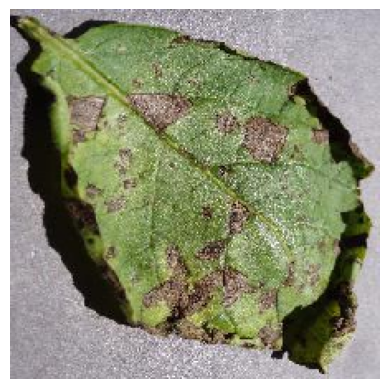

In [16]:
show_image(*train_data[0],class_names)

Label: Peach___Bacterial_spot (16)



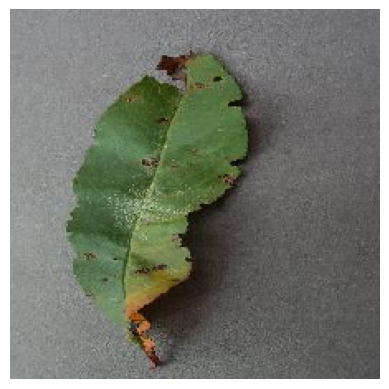

In [17]:
show_image(*train_data[700],class_names)

Label: Peach___Bacterial_spot (16)



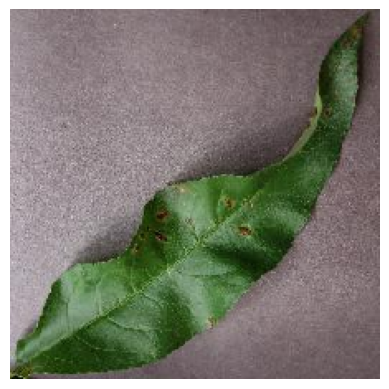

In [18]:
show_image(*train_data[300],class_names)

In [19]:
def show_batch(data):
    
    images, labels = next(data)
    
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.set_xticks([])  
    ax.set_yticks([])  
    
    grid_size = 8
    num_images = grid_size * grid_size
    
    selected_images = images[:min(num_images, len(images))]

    rows = []
    for i in range(len(selected_images) // grid_size):
        rows.append(np.concatenate(selected_images[i*grid_size:(i+1)*grid_size], axis=1))
    
    if len(selected_images) % grid_size != 0:
        rows.append(np.concatenate(selected_images[len(selected_images) // grid_size * grid_size:], axis=1))
    
    grid_img = np.concatenate(rows, axis=0)
    
    ax.imshow(grid_img)
    plt.show()

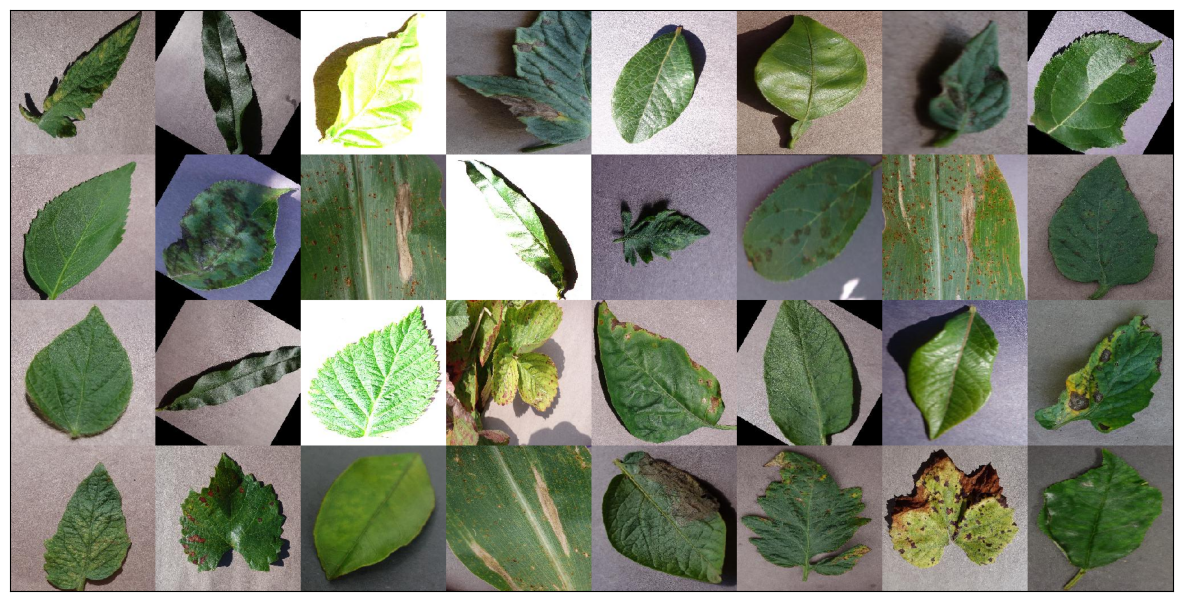

In [20]:
show_batch(train_data)

In [21]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

***Training Model***

In [22]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2)
])

In [23]:
train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
val_dataset = image_dataset_from_directory(
    valid_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.


In [24]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [25]:
x = tf.keras.Sequential([
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(len(train_dataset.class_names), activation="softmax")
])

output = x(base_model.output)

In [26]:
model = Model(inputs=base_model.input, outputs=output)

In [27]:
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.002),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [28]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=2
)

Epoch 1/2
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 145s 60ms/step - accuracy: 0.6102 - loss: 1.3447 - val_accuracy: 0.9239 - val_loss: 0.2370
Epoch 2/2
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 120s 55ms/step - accuracy: 0.7928 - loss: 0.6583 - val_accuracy: 0.9360 - val_loss: 0.2058


In [29]:
for layer in base_model.layers[-50:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [30]:
history_fine = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=2
)

Epoch 1/2
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 224s 91ms/step - accuracy: 0.8630 - loss: 0.4766 - val_accuracy: 0.9752 - val_loss: 0.0881
Epoch 2/2
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 185s 84ms/step - accuracy: 0.9529 - loss: 0.1551 - val_accuracy: 0.9846 - val_loss: 0.0539


In [31]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 59,091,700 (225.42 MB)

 Trainable params: 17,484,838 (66.70 MB)

 Non-trainable params: 6,637,184 (25.32 MB)

 Optimizer params: 34,969,678 (133.40 MB)

In [32]:
model.evaluate(val_dataset)

550/550 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.9831 - loss: 0.0601


[0.05385641008615494, 0.9845777153968811]

In [33]:
def plot_accuracies(history):
    plt.plot(history.history['accuracy'], '-bx', label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], '-rx', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy vs. Epochs')
    plt.show()

def plot_losses(history):
    plt.plot(history.history['loss'], '-bx', label='Training Loss')
    plt.plot(history.history['val_loss'], '-rx', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss vs. Epochs')
    plt.show()


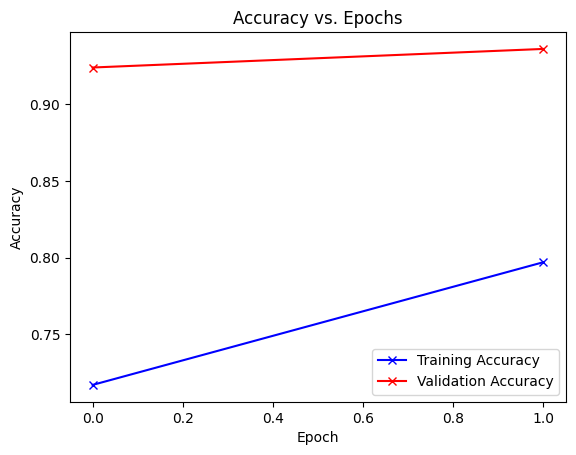

In [34]:
plot_accuracies(history)

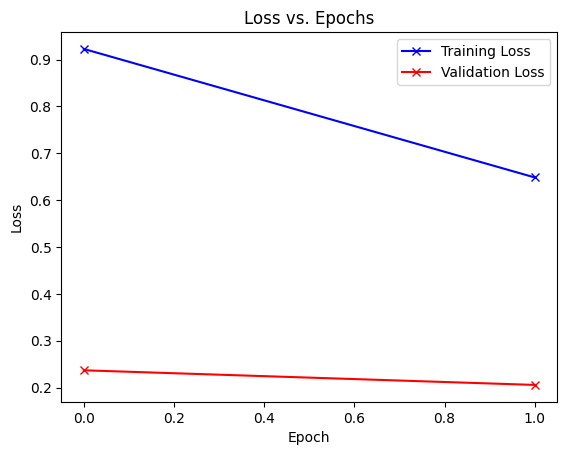

In [35]:
plot_losses(history)

***Saving Models***

In [ ]:
model.save("/kaggle/working/model.h5")

In [ ]:
import json
with open("/kaggle/working/class_names.json", "w") as f:
    json.dump(train_dataset.class_names, f)